# Topology optimization of a 2D heat sink
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/optimization/planar/topology_thermal_static.ipynb)

Inspired by [Dolfin Adjoint Tutorial](://www.dolfin-adjoint.org/en/stable/documentation/poisson-topology/poisson-topology.html).


The model is defined on the square $\Omega$ with length $L=1\,\text{m}$. An homogenous heat source of $q=100\,\text{W}/\text{m}^2$ is applied to the solution domain.
Simple isotropic Fourier's law connects diffusive heat flux $\boldsymbol{h}$ and temperature gradient via the scalar conductivity $\kappa=400\,\mathrm{W}/\mathrm{m\,K}$.

Homogenous Neumann boundary conditions are prescribed at the `south` and `east` edges. 
A constant Dirichlet temperature BC $T_D= 0\,\mathrm{K}$ is prescribed on the `west` and `north` edges.
Then, the Poisson-like PDE is defined as:

$$\begin{align}
\mathrm{div}\left(  \kappa \, \mathrm{grad}\left( T \right) \right) + q =  0 \quad &\in \Omega,\\
\boldsymbol{h}\cdot\boldsymbol{n} = 0 \quad &\in \partial\Omega_\text{N},\\
T = T_\text{D} \quad &\in \partial\Omega_\text{D}.
\end{align}$$

#### Definition of constants.

In [1]:
L = 1.0
n_elements = 300

heat_source = 1000  
T_D = 0.0
kappa = 400.0  # W / m / K


Using the configuration, we can build the FEM model representing the solution domain.

In [2]:
import meshzoo
import torch
import numpy as np

torch.set_default_dtype(torch.double)

from torchfem import PlanarHeat
from torchfem.materials import IsotropicConductivity2D

from matplotlib import animation
from torchfem.plot_utils import embed_animation_gif

from scipy.optimize import bisect
from tqdm import tqdm


# Material model (plane stress)
material = IsotropicConductivity2D(kappa=kappa, cp=1.0, rho=1.0)

#
_points, _cells = meshzoo.rectangle_quad(
    torch.linspace(0.0, L, n_elements + 1).numpy(),
    torch.linspace(0.0, L, n_elements + 1).numpy(),
    cell_type="quad4",
)

nodes = torch.as_tensor(_points, dtype=torch.get_default_dtype())
elements = torch.as_tensor(_cells.tolist())

model = PlanarHeat(nodes, elements, material)

west = torch.isclose(nodes[:, 0], nodes[:, 0].min())
north = torch.isclose(nodes[:, 1], nodes[:, 1].max())


dirichlet_edges = west | north

# constraints at west and north
model.constraints[dirichlet_edges] = True
model.displacements[dirichlet_edges] = T_D

# distribute load to nodes:
element_volume = model.integrate_field()
cf = element_volume / element_volume.sum()
heat_source_per_element = cf * heat_source

nodal_fluxes = model.assemble_force(
    heat_source_per_element.unsqueeze(1).repeat(1, model.etype.nodes) 
) / model.etype.nodes

model.forces[:, 0] = nodal_fluxes


u, *_ = model.solve()
# model.plot(node_property=u.squeeze(), linewidth=0.0)

Instead of sensitivity filtering, we penalize the conventional objective $\mathcal{F}$ using Tikhonov regularization.

$$\mathcal{F} = \underline{T}\, \underline{f}^\top + \alpha \int_\Omega \left\lVert \frac{\partial \rho} {\partial \boldsymbol{x}} \right\rVert^2 \, \mathrm{d}V  $$

The first term is the "thermal compliance" Yet, some authors argue that it bears little physical interpretability (in contrast to mechanical compliance) and adjusting the objective to minimizing  the temperature variance being a more natural choice [[1]](https://doi.org/10.1109/TCPMT.2021.3120383). 

Under a minimal volume constraint the optimization problem reads:

$$
\min_{\rho \left( \boldsymbol{x} \right)} \left( \mathcal{F} \right)\quad\text{s.t.}\, \int_\Omega \rho \, \mathrm{d}V \leq V_0.
$$

To compute meaningful spatial gradients of the design varibale, we have to initialize $\rho$ at nodes and interpolate it to element centroids in the forward pass.


In [3]:
# Parameters
vol_frac = 0.4  # volume fraction
p = 3.0
move = 0.1
alpha = 1.0

kappa_min = 1.0  # W / m / K

In [4]:
# evaluate N, N,x and detJ at element centroids
element_centroid = model.etype.ipoints.sum(dim=0)  # exploit regularity of the mesh
weight_sum = model.etype.iweights.sum()

N, B, detJ = model.eval_shape_functions(element_centroid)

# Initial, minimum, and maximum values of design variables
rho_nodes0 = vol_frac * torch.ones(len(nodes), requires_grad=True)
rho_min = kappa_min / kappa * torch.ones_like(rho_nodes0)
rho_max = torch.ones_like(rho_nodes0)

#
V_0 = vol_frac * element_volume.sum()

In [5]:
# runs for approx. 2 minutes on M1 MBA

def optimize(rho_nodes0, n_iter=50, alpha=0.0):
    rho_nodes = [rho_nodes0]
    temperature = []

    # Iterate solutions
    for k in tqdm(range(n_iter)):
        # Adjust thickness variables
        
        # interpolate rho at element centroids
        rho_k = torch.einsum("EN, N -> E", rho_nodes[k][elements], N)
        # only for isotropic material -> same effect as updating kappa
        model.thickness = rho_k ** p
        # model.material = material.vectorize(model.n_elem)
        # model.material.KAPPA = rho_k[:, None, None] ** p * model.material.KAPPA

        # Compute solution
        u_k, f_k, hfl, _, _ = model.solve()

        # compute gradient of rho
        grad_rho = torch.einsum("EiN, EN -> Ei", B, rho_nodes[k][elements])
        regularization_term = torch.einsum("Ei, Ei, E ->", grad_rho, grad_rho, detJ)
        # temperature_variance = u_k.var()
        # Evaluation of compliance
        objective = torch.inner(f_k.ravel(), u_k.ravel()) + alpha * regularization_term
        # automatic differentiation.
        sensitivity = torch.autograd.grad(objective, rho_nodes[k])[0]


        # For a certain value of mu, apply the iteration scheme
        def make_step(mu):
            G_k = -sensitivity / mu
            # reasoning of OC may be violated here, clamping works to some extent :o 
            G_k = G_k.clamp(0.0, 1.0e127) 
            upper = torch.min(rho_max, (1 + move) * rho_nodes[k])
            lower = torch.max(rho_min, (1 - move) * rho_nodes[k])
            # CK: why the sqrt? is this not just fix point iteration
            rho_trial = G_k**0.5 * rho_nodes[k]  
            return torch.maximum(torch.minimum(rho_trial, upper), lower)

        # Constraint function
        def g(mu):
            rho_nodes_it = make_step(mu)
            rho_k = torch.einsum("EN, N -> E", rho_nodes_it[elements], N)
            return torch.inner(element_volume, rho_k)  - V_0

        # Find the root of g(mu)
        with torch.no_grad():
            mu = bisect(g, 0.0, 100000.0)

        rho_nodes.append(make_step(mu))
        temperature.append(u_k)
        
    return rho_nodes, temperature

In [6]:
rho_nodes, temperature = optimize(rho_nodes0, alpha=0.0)
rho_nodes_reg, temperature_reg = optimize(rho_nodes0, alpha=2.0)

100%|██████████| 50/50 [02:02<00:00,  2.44s/it]


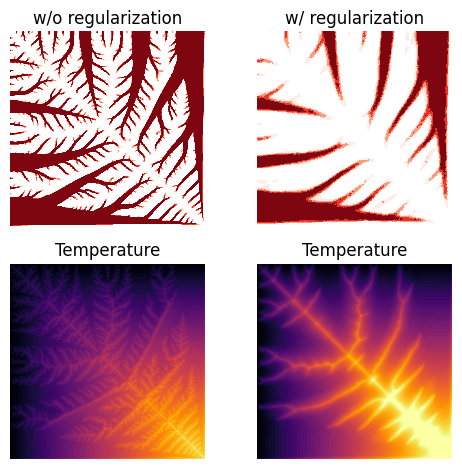

In [7]:
# Define vmin and vmax
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt

vmin, vmax = 0.5, 1.0

# Create a colormap based on viridis, but set under-range color to white
cmap = plt.cm.Reds.copy()
cmap.set_under("white")  # values below vmin will be white

# Create a normalization that respects vmin/vmax
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
with torch.no_grad():
    # ridicously slow, propose using pyvista in combination with meshio
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    model.plot(
        node_property=rho_nodes[-1],
        cmap=cmap,
        norm=norm,
        vmin=vmin,
        vmax=vmax,
        linewidth=0.0,
        bcs=False,
        ax=ax1,
        title="w/o regularization"
    )
    model.plot(
        node_property=rho_nodes_reg[-1],
        cmap=cmap,
        norm=norm,
        vmin=vmin,
        vmax=vmax,
        linewidth=0.0,
        bcs=False,
        ax=ax2,
        title="w/ regularization"
    )
    model.plot(
        node_property=temperature[-1].squeeze(),
        cmap="inferno",
        # norm=norm,
        vmin=temperature[-1].min(),
        vmax=temperature[-1].max(),
        linewidth=0.0,
        bcs=False,
        ax=ax3,
        title="Temperature",
        levels=100
    )
    model.plot(
        node_property=temperature_reg[-1].squeeze(),
        cmap="inferno",
        # norm=norm,
        vmin=temperature[-1].min(),
        vmax=temperature[-1].max(),
        linewidth=0.0,
        bcs=False,
        ax=ax4,
        title="Temperature",
        levels=100
    )
    fig.set_tight_layout("tight")

In [ ]:
# # Much faster alternative, use meshio interface and let pyvista handle the heavy lifting  

# import pyvista as pv
# import meshio as mo

# idx = -1
# mo.CellBlock(cell_type="quad", data=_cells)

# mesh = mo.Mesh(_points, [mo.CellBlock("quad", _cells)])
# mesh.point_data["rho"] = rho_nodes[idx].detach().numpy()
# mesh.point_data["rho_reg"] = rho_nodes_reg[idx].detach().numpy()
# mesh.point_data["T"] = temperature[idx].detach().numpy().ravel()
# mesh.point_data["T_reg"] = temperature_reg[idx].detach().numpy().ravel()
# mesh.point_data["T0"] = temperature[0].detach().numpy().ravel()

# ug = pv.from_meshio(mesh)
# ug = ug.cell_data_to_point_data()
# ug.set_active_scalars("rho_reg")
# ug_clipped = ug.clip_scalar(value=0.5, invert=False)

# contours = ug.contour(12, scalars="rho")
# # 
# # ss.plot()
# pl = pv.Plotter()
# pl.add_mesh(ug_clipped, color="black")
# # pl.add_mesh(ug, scalars="rho", cmap="Reds")
# pl.add_mesh(ug.extract_feature_edges(), color="black")
# # pl.add_mesh(contours, cmap="Reds", line_width=5.0)
# pl.show()
